Load in the data

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import scanpy as sc
import re
from tqdm import tqdm
import anndata as ad
tqdm.pandas()

base_dir = "/home/jrich/Desktop/CART_prostate_sc"  # os.path.dirname(os.path.dirname(__file__))
run_id = "SAMN10988512_SRX5414523_SRR8615230"


data_folder = os.path.join(base_dir, 'data')
output_figure_dir = os.path.join(data_folder, 'output', run_id, 'figures', 'preprocessing')
output_data_dir = os.path.join(data_folder, 'output', run_id, 'data')
counts_unfiltered_dir = os.path.join(data_folder, 'aligned', run_id, 'kb_outs', 'counts_unfiltered')

if not os.path.exists(output_figure_dir):
    os.makedirs(output_figure_dir)

if not os.path.exists(output_data_dir):
    os.makedirs(output_data_dir)

adata = ad.read_h5ad(f"{counts_unfiltered_dir}/adata.h5ad")

# import kb_python.utils as kb_utils
# adata = kb_utils.import_matrix_as_anndata(f"{counts_unfiltered_dir}/cells_x_genes.mtx", f"{counts_unfiltered_dir}/cells_x_genes.barcodes.txt",
# f"{counts_unfiltered_dir}/cells_x_genes.genes.names.txt")

adata.var['header'] = adata.var.index

# adata.X.todense()
# adata.obs
# adata.var

# IF I split reads by Ns, then run kb extract on ins and delins and ensure that I don't double-count
- splitting reads by N will never double count because the shorter side will always be length < k

In [ ]:
# TODO: write this function

# Increment adata matrix based on falsely-removed reads from d-list - untested on real data

In [ ]:
from varseek.utils import increment_adata_based_on_dlist_fns
dlist_file = ""
if dlist_file:
    # TODO: check if I need to add --mm here
    adata = increment_adata_based_on_dlist_fns(adata = adata, vcrs_fasta = vcrs_fasta, dlist_fasta = dlist_fasta_delaney, kb_count_out = kb_count_out_delaney, index = mutation_reference_file_index_with_dlist_delaney, t2g = vcrs_t2g, fastq = test_fastq, newer_kallisto = newer_kallisto, k=k, mm=multimapping, bustools="/home/jrich/miniconda3/envs/cartf/lib/python3.10/site-packages/kb_python/bins/linux/bustools/bustools")

In [ ]:
cosmic_reference_path = '/home/jrich/Desktop/CART_prostate_sc/data/reference/COSMIC/GRCh37/CancerMutationCensus_AllData_Tsv_v100_GRCh37/CancerMutationCensus_AllData_v100_GRCh37_gget_mutate.csv'

# Load the CSV file into a DataFrame
reference_df = pd.read_csv(cosmic_reference_path)

if bulk data, consider doing QC the normal sample x *gene* matrix (not sample x mutation):

if single-cell data, consider doing QC and isolating just cancer cells based on the normal cell x *gene* matrix (not cell x mutation):

Approach 1) the scanpy way (see below)
- min counts per cell
- min genes per cell
- doublet detection (scrublet)
- High MT and/or Rb content - but if these are high in cancer cells, then perhaps I don’t want to do this?
- clustering cells and selecting only the cancerous clusters

In [2]:
# adata_regular_alignment = sc.read_10x_h5('adata_regular_alignment.h5ad')
# adata_regular_alignment.var_names_make_unique()
# adata_regular_alignment.obs_names_make_unique()

# # QC
# min_counts_assessed_by_knee_plot = 0  #! adjust based on knee plot
# sc.pp.filter_cells(adata_regular_alignment, min_counts=min_counts_assessed_by_knee_plot)  # filter cells by min counts
# sc.pp.filter_cells(adata_regular_alignment, min_genes=100)  # filter cells by min genes
# sc.pp.filter_genes(adata_regular_alignment, min_cells=3)  # filter genes by min cells
# adata_regular_alignment.var["mt"] = adata_regular_alignment.var_names.str.startswith("MT-")
# sc.pp.calculate_qc_metrics(adata_regular_alignment, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
# adata_regular_alignment = adata_regular_alignment[adata_regular_alignment.obs.pct_counts_mt < 5, :].copy()  # filter cells by high MT content
# sc.pp.scrublet(adata_regular_alignment, batch_key="sample")  # filter doublets

# # log normalization
# sc.pp.normalize_total(adata_regular_alignment)
# sc.pp.log1p(adata_regular_alignment)

# # HVGs
# sc.pp.highly_variable_genes(adata_regular_alignment, n_top_genes=2000, batch_key="sample")

# # PCA
# sc.tl.pca(adata_regular_alignment)

# # KNN/SNN
# sc.pp.neighbors(adata_regular_alignment)

# # Clustering
# sc.tl.leiden(adata_regular_alignment, flavor="igraph", n_iterations=2)

# # DE
# sc.tl.rank_genes_groups(adata_regular_alignment, groupby="leiden_res_0.50", method="wilcoxon")
# sc.pl.rank_genes_groups_dotplot(adata_regular_alignment, groupby="leiden_res_0.50", standard_scale="var", n_genes=5)

# # mark cancer vs noncancer cells/samples, and save this list of cancer cells/samples

if single-cell data, consider doing QC and isolating just cancer cells based on the normal cell x *gene* matrix (not cell x mutation):

Approach 2) The mx way

insert here - load in data to adata_regular_alignment

QC
*mx filter*

log normalization
*mx normalize* (both CPM and log1p normalization)

identify cancer-specific marker genes from the literature ("old")
uncertain: derive a list of marker genes from the normalized count matrix data as "new" and merge with ld using *ec merge*?

* Iteratively run the following process (starting from old marker gene list)
- run *ec index* on the marker list
- run *mx extract* on the output of *ec index*
- run *mx clean* on the output of *mx extract*
- run *mx assign* on the output of *mx clean*
- run *mx diff* on the output of *mx assign* to produce new marker genes ("new")
- merge old and new marker genes with *ec merge*
- iteratively repeat the process starting from *ec index* on the newly merged marker genes until I arrive at a list of cell type assignments out of *mx assign* that I am satisfied with

In [ ]:
# mx implementation...

Filter adata by inclusion or exclusion criteria in the header

In [3]:
included_transcripts = []
included_genes = []
included_mutations = []

excluded_transcripts = []
excluded_genes = []
excluded_mutations = []


def perform_filtering(adata, transcript_list = None, gene_list = None, mutation_list = None, type = ""):
    if not transcript_list:
        transcript_list = []
    if not gene_list:
        gene_list = []
    if not mutation_list:
        mutation_list = []
    entry_list = transcript_list + gene_list + mutation_list
    if type == "inclusion":
        if entry_list:
            for row in adata.var.index:
                if row not in entry_list:
                    print(f"Warning: {row} not found in the {type} list. Removing.")
                    adata.var.drop(row, inplace=True)
    elif type == "exclusion":
        if entry_list:
            for row in adata.var.index:
                if row in entry_list:
                    print(f"Warning: {row} found in the {type} list. Removing.")
                    adata.var.drop(row, inplace=True)
    else:
        print("Error: type must be either inclusion or exclusion")

perform_filtering(adata, included_transcripts, included_genes, included_mutations, "inclusion")
perform_filtering(adata, excluded_transcripts, excluded_genes, excluded_mutations, "exclusion")

Remove ambiguous kmers (ie kmers which were not specific to a single mutation)

In [4]:
remove_ambiguous_kmers = False

if remove_ambiguous_kmers:
    adata.var = adata.var[~adata.var.index.str.contains(';')]
    # filtered_var = adata.var[~adata.var.index.str.contains(';')]
    # adata = adata[:, filtered_var.index]

## Do CPM normalization on the *mutation* matrix for each cell/sample manually based on the scaling factors from the *gene* matrix

## log1p transform the mutation matrix

## if multiple cells/samples --> make PCA plot (colored by subgrouping and/or labelled with text if desired)

## plot mutation expression (or some other metric) by mutation
- if 1 cell/sample only --> plot as descending line plot (y mutation expression, x mutation) - I already do this in notebook 3
- if multiple cells/samples --> plot as heatmap across cells/samples with seaborn (color mutation expression, x mutation, y cell/sample)
    - if a small number of cell/samples (i.e., < 10) --> plot a descending line plot for each cell/sample

In [5]:
# this part assumes 1 cell/sample only
transcript_counts = adata.X.sum(axis=0).A1  # .A1 converts the sparse matrix to a dense array

# Add this as a new column to adata.var
adata.var['transcript_count'] = transcript_counts

# Sort the genes by the transcript count in descending order
adata.var = adata.var.sort_values(by='transcript_count', ascending=False)

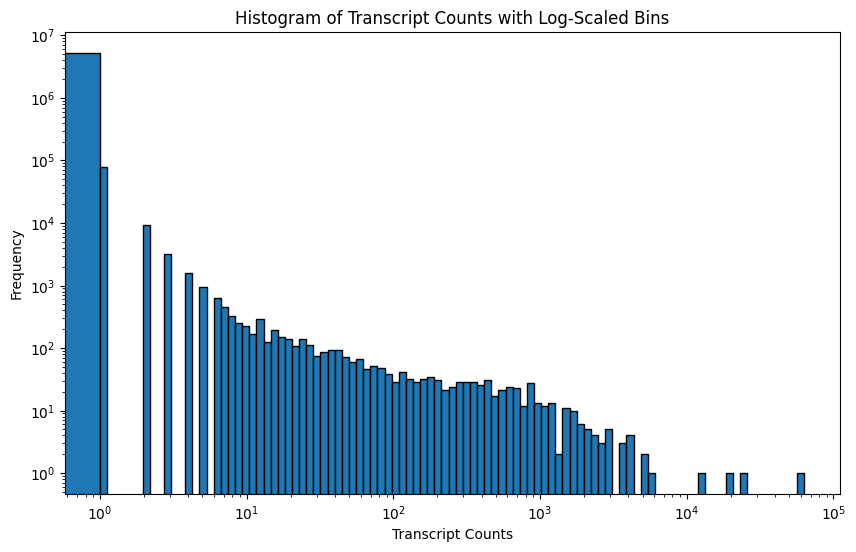

In [6]:
# Define log-spaced bins including a bin for 0 to 1
bins = np.logspace(0, np.log10(adata.var['transcript_count'].max() + 1), num=100)
bins = np.insert(bins, 0, 0)  # Insert 0 at the beginning

# Plot the histogram with log-scaled bins
plt.figure(figsize=(10, 6))
plt.hist(adata.var['transcript_count'], bins=bins, edgecolor='black')
plt.xlabel('Transcript Counts')
plt.ylabel('Frequency')
plt.xscale('log')
plt.yscale('log')
plt.title('Histogram of Transcript Counts with Log-Scaled Bins')
plt.savefig(f'{output_figure_dir}/count_histogram.png', dpi=300)
plt.show()

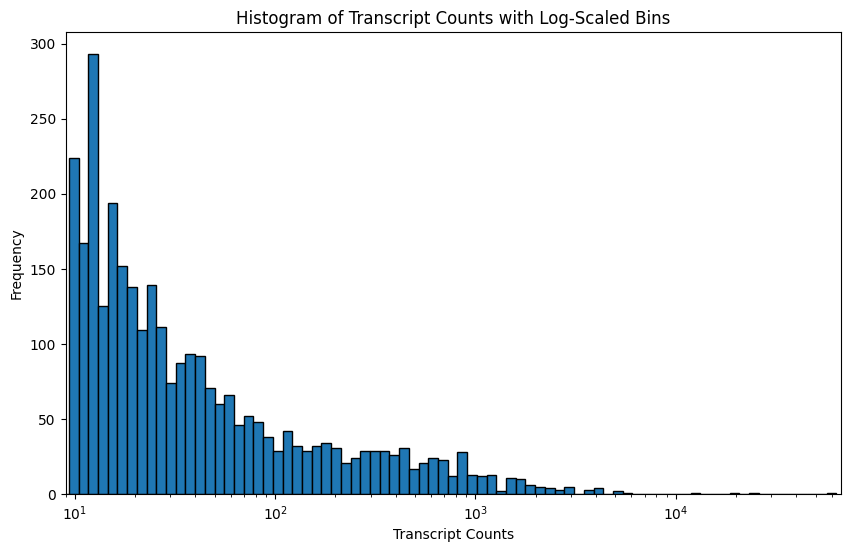

In [15]:
threshold = 10

# Filter out zeros from the transcript_count column
filtered_transcript_counts = adata.var['transcript_count'][adata.var['transcript_count'] >= threshold]


# Plot the histogram with log-scaled bins
plt.figure(figsize=(10, 6))
plt.hist(filtered_transcript_counts, bins=bins, edgecolor='black')
plt.xlabel('Transcript Counts')
plt.xlim(left=threshold-1)
plt.ylabel('Frequency')
plt.xscale('log')
# plt.yscale('log')
plt.title('Histogram of Transcript Counts with Log-Scaled Bins')
plt.savefig(f'{output_figure_dir}/count_histogram.png', dpi=300)
plt.show()


In [11]:
minimum_mutations = 2
adata = adata[:, adata.var['transcript_count'] >= minimum_mutations].copy()  # filter out mutations with less than 2 counts

/tmp/ipykernel_110058/3771285257.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


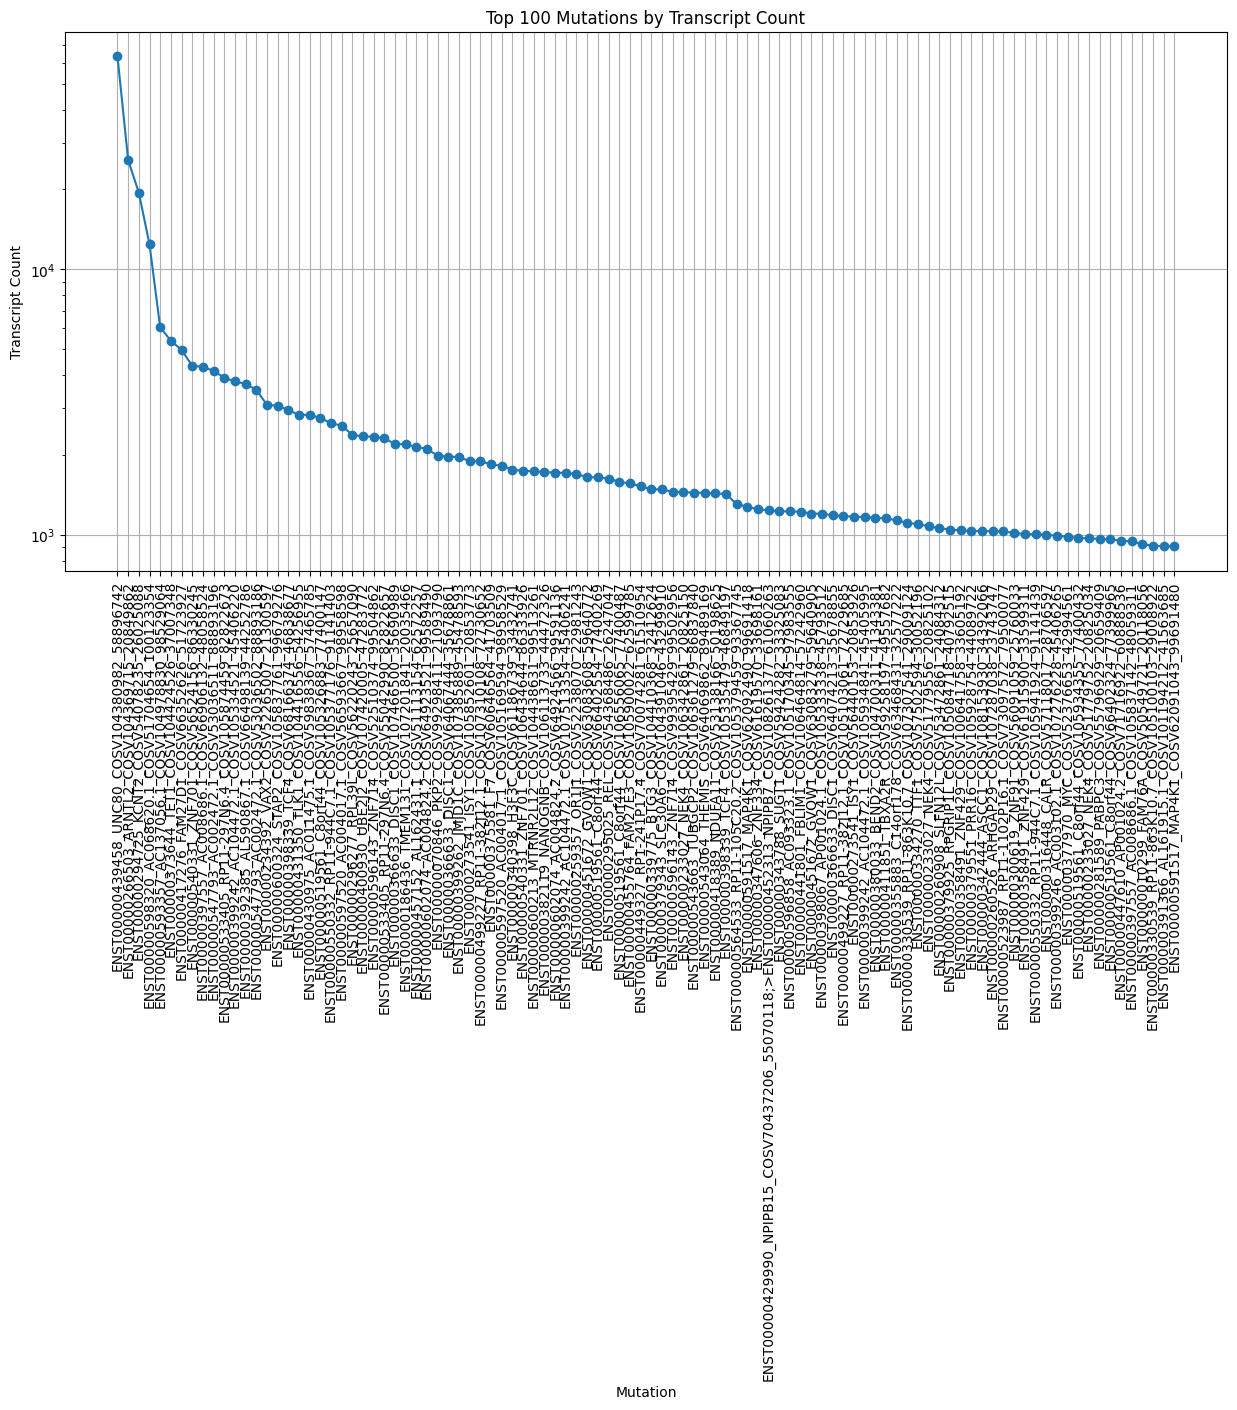

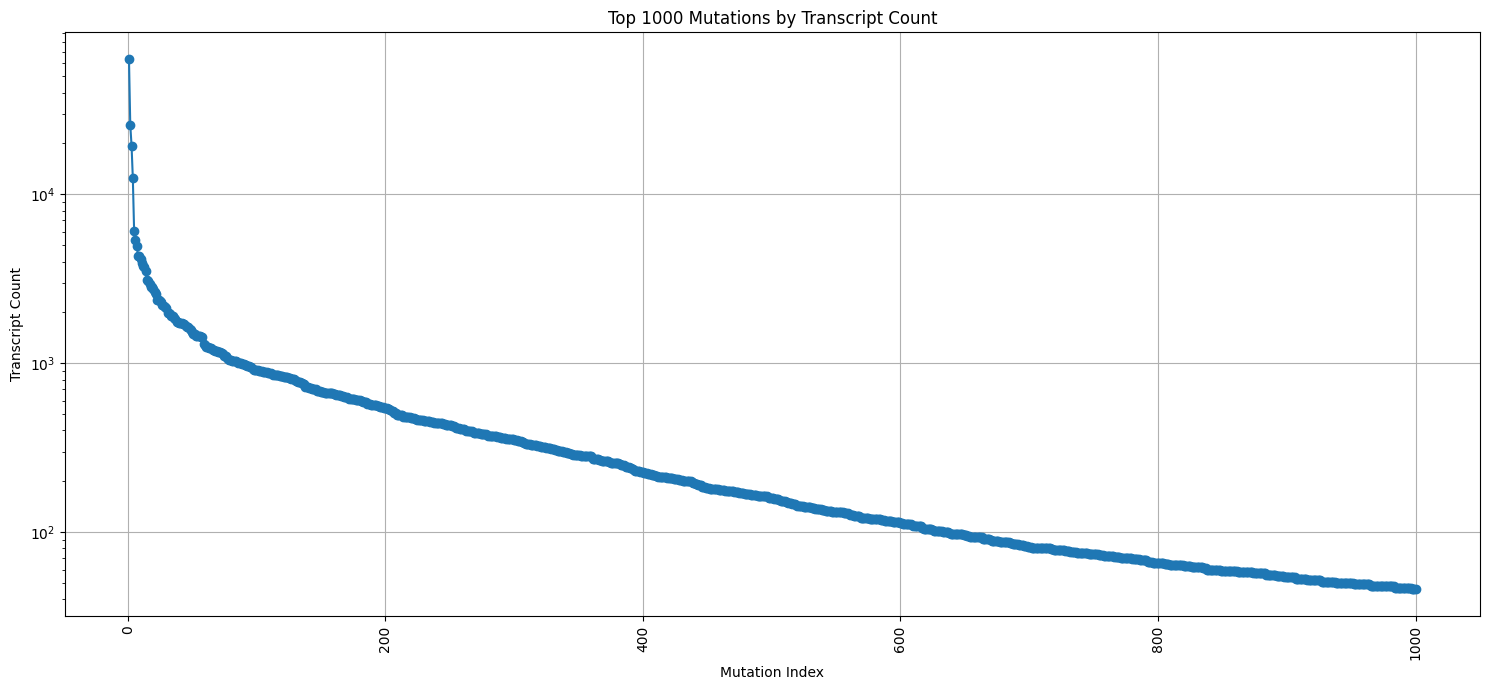

In [12]:
from varseek.utils import plot_items_descending_order

plot_items_descending_order(adata.var, x_column = 'header', y_column = 'transcript_count', item_range = (0,100), xlabel = "Mutation", title = "Top 100 Mutations by Transcript Count", save_path = f'{output_figure_dir}/top_100_mutations_plot.png', figsize = (15, 7))
plot_items_descending_order(adata.var, x_column = 'header', y_column = 'transcript_count', item_range = (0,1000), xlabel = "Mutation Index", title = "Top 1000 Mutations by Transcript Count", save_path = f'{output_figure_dir}/top_1000_mutations_plot.png', figsize = (15, 7))

In [13]:
from tqdm import tqdm

def extract_and_join(data):
    groups = []

    for item in tqdm(data, desc="Processing items"):
        subgroups = []
        # Split by semicolon first
        semicolon_split_items = item.split(';')
        colon_split_items = [split_item.split(':') for split_item in semicolon_split_items]

        # Initialize subgroups if empty
        if not groups:
            for _ in range(len(colon_split_items[0])):
                groups.append([])

        # Populate subgroups
        for subitem in colon_split_items:
            for idx, value in enumerate(subitem):
                if len(subgroups) <= idx:
                    subgroups.append([])
                subgroups[idx].append(value)

        # Join subgroups with semicolons
        for idx in range(len(subgroups)):
            if len(subgroups[idx]) > 1:
                joined_subgroup = ';'.join(subgroups[idx])
            else:
                joined_subgroup = subgroups[idx][0]
            groups[idx].append(joined_subgroup)

    return groups

# result = extract_and_join_alternative(["xxx_yyy_zzz", "bbb_ccc_ddd"])
# result = extract_and_join(list(adata.var.index)[60:63])
# for group in result:
#     print(group)

In [14]:
result = extract_and_join(list(adata.var.index))

Processing items: 100%|██████████| 19850/19850 [00:00<00:00, 182269.62it/s]


In [15]:
adata.var['seq_ID'] = result[0]
adata.var['mutation'] = result[1]

adata.var = adata.var.merge(reference_df, how='left', left_on=['seq_ID', 'mutation'], right_on=['seq_ID', 'Mutation CDS'])

In [16]:
# search_value = "COSV73388642"
# position = next((i for i, item in enumerate(list(adata.var.index)) if search_value in item), None)
# position

# adata.var.index[0]  # no semicolon 'ENST00000347606_ZNF334_COSV61619570_33698161'
# adata.var.index[61]  # 1 semicolon 'ENST00000429990_NPIPB15_COSV70437206_55070118;>ENST00000452313_NPIPB7_COSV108261377_61060263'
# adata.var.index[856]  # 3 semicolons 'ENST00000540273_PPIAL4B_COSV73388642_86074765;>ENST00000539781_PPIAL4A_COSV73346204_83923559;>ENST00000369222_PPIAL4C_COSV65042565_38625297;>ENST00000419275_PPIAL4G_COSV70086757_52379019'

In [17]:
adata.uns['combined_transcripts'] = adata.var.groupby(['gene_name', 'seq_ID'], as_index=False)['transcript_count'].sum().sort_values(by='transcript_count', ascending=False)
# adata.uns['combined_gene'] = adata.var.groupby(['gene_name'], as_index=False)['transcript_count'].sum().sort_values(by='transcript_count', ascending=False)

# Include ENSTs in adata.uns['combined_genes']
combined_gene = adata.var.groupby('gene_name', as_index=False)['transcript_count'].sum()
combined_gene = pd.merge(combined_gene, adata.var[['gene_name', 'seq_ID']], on='gene_name', how='left')
combined_gene = combined_gene.drop_duplicates(subset='gene_name', keep='first')
adata.uns['combined_genes'] = combined_gene.sort_values(by='transcript_count', ascending=False)

Run this to also add ENSG symbols from ENST symbols to adata.uns['combined_genes']

In [18]:
# from scripts.map_enst_to_ensg import get_ensembl_gene_id
# adata.uns['combined_genes']['ensembl_gene_id'] = adata.uns['combined_genes']['seq_ID'].progress_apply(get_ensembl_gene_id)

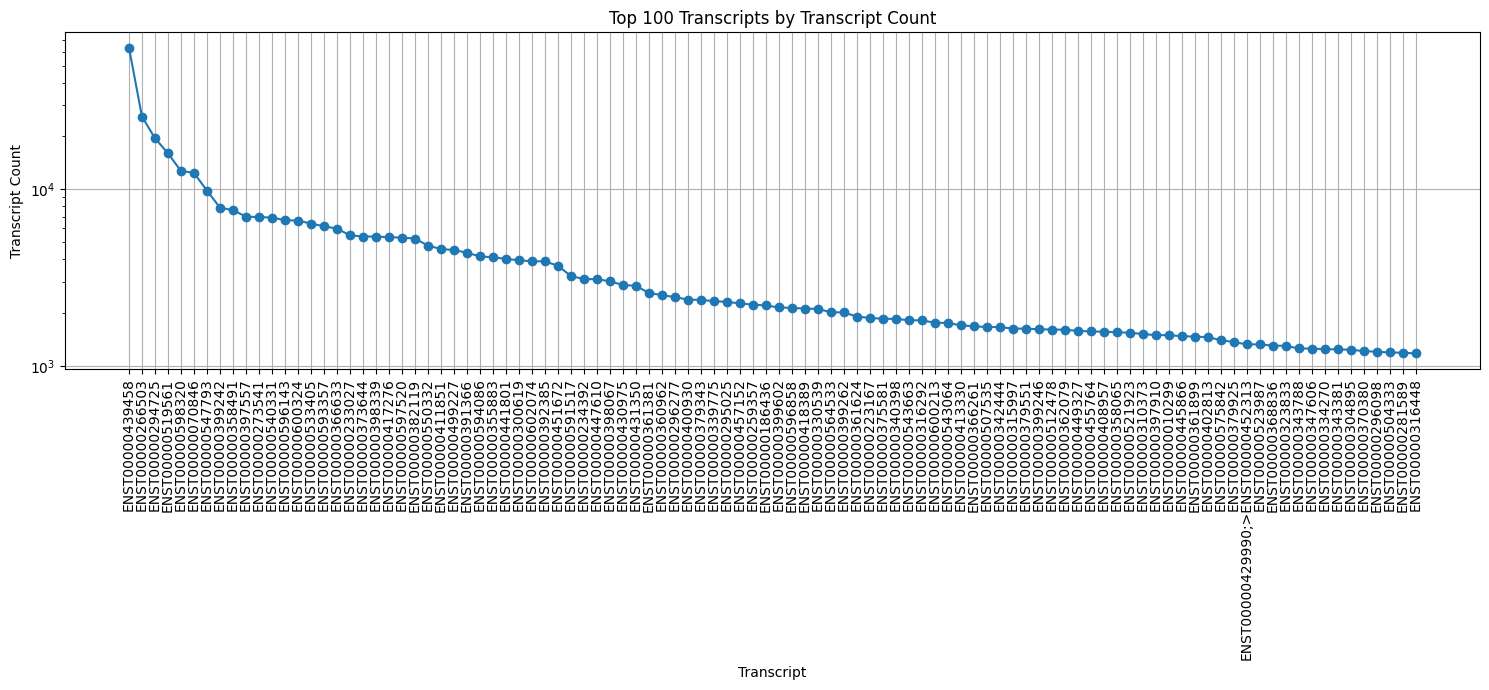

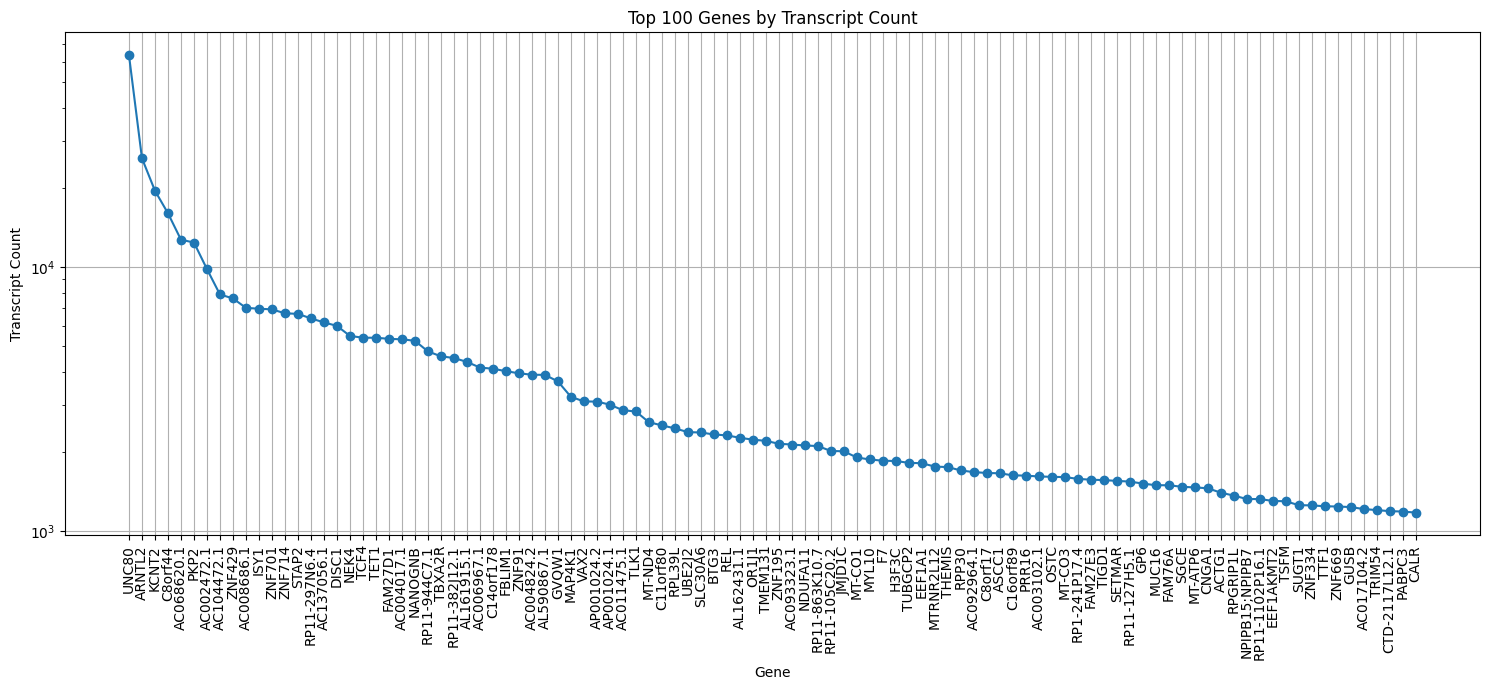

In [20]:
plot_items_descending_order(adata.uns['combined_transcripts'], x_column = 'seq_ID', y_column = 'transcript_count', item_range = (0,100), xlabel = "Transcript", title = "Top 100 Transcripts by Transcript Count", save_path = f'{output_figure_dir}/top_100_transcripts_plot.png', figsize = (15, 7))
plot_items_descending_order(adata.uns['combined_genes'], x_column = 'gene_name', y_column = 'transcript_count', item_range = (0,100), xlabel = "Gene", title = "Top 100 Genes by Transcript Count", save_path = f'{output_figure_dir}/top_100_genes_plot.png', figsize = (15, 7))

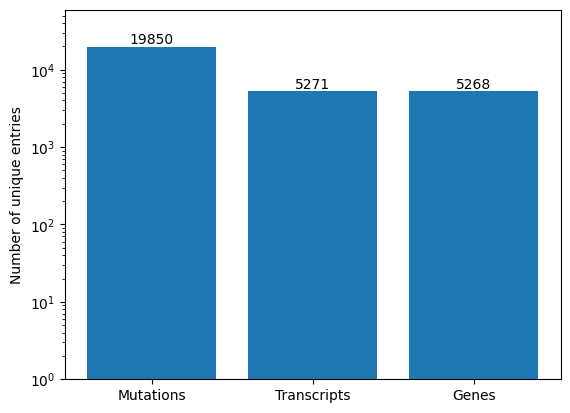

In [21]:
numbers = {'Mutations': adata.shape[1], 'Transcripts': adata.uns['combined_transcripts'].shape[0], 'Genes': adata.uns['combined_genes'].shape[0]}

plt.bar(list(numbers.keys()), list(numbers.values()))
# plt.plot(list(numbers.keys()), list(numbers.values()), marker='o')  # if I prefer line graph instead of bar graph

# Add a title and labels
plt.ylabel('Number of unique entries')
plt.yscale('log')
plt.ylim(1, max(list(numbers.values())) * 3)

for i, value in enumerate(numbers.values()):
    plt.text(i, value, f'{value}', ha='center', va='bottom')

# Show the plot
plt.savefig(f'{output_figure_dir}/unique_entries.png', dpi=300)
plt.show()

In [22]:
# number of mutations with identical 61-mers
adata.var['header'].str.contains(';').sum()

272

In [25]:
from gget.utils import read_fasta

sequences = '/home/jrich/Desktop/CART_prostate_sc/data/reference/GRCh_Ensembl/GRCh37/Homo_sapiens.GRCh37.cds.all.fa'

titles, seqs = read_fasta(sequences)

seq_dict = {}
for title, seq in zip(titles, seqs):
    # Keep text following the > until the first space/dot as the sequence identifier
    # Dots are removed so Ensembl version numbers are removed
    seq_dict[title.split(" ")[0].split(".")[0]] = seq

adata.var["full_sequence"] = adata.var["seq_ID"].map(seq_dict)

In [26]:
variant_type = np.full(len(adata.var), 'unknown', dtype=object)
variant_type[adata.var['mutation'].str.contains('>', na=False)] = 'substitution'
variant_type[adata.var['mutation'].str.contains('delins', na=False)] = 'delins'
variant_type[(adata.var['mutation'].str.contains('ins', na=False)) & (~adata.var['mutation'].str.contains('delins', na=False))] = 'insertion'
variant_type[(adata.var['mutation'].str.contains('del', na=False)) & (~adata.var['mutation'].str.contains('delins', na=False))] = 'deletion'
variant_type[adata.var['mutation'].str.contains('dup', na=False)] = 'duplication'
variant_type[adata.var['mutation'].str.contains('inv', na=False)] = 'inversion'

adata.var['variant_type'] = variant_type

In [27]:
# Define the pattern
pattern = r'c\.(\d+)[a-zA-Z]?(_(\d+)[a-zA-Z]?)?'

# Use str.extract to apply the pattern to the 'mutation' column
extracted = adata.var['mutation'].str.extract(pattern)

# Extracted columns are 0, 1, 2 based on the pattern groups
adata.var['start_nucleotide'] = extracted[0].astype(float)
adata.var['end_nucleotide'] = extracted[2].fillna(extracted[0]).astype(float)

In [28]:
adata.var['sequence_length'] = adata.var['full_sequence'].str.len()

In [29]:
adata.var['start_nucleotide_reverse'] = adata.var['sequence_length'] - adata.var['end_nucleotide']
adata.var['end_nucleotide_reverse'] = adata.var['sequence_length'] - adata.var['start_nucleotide']

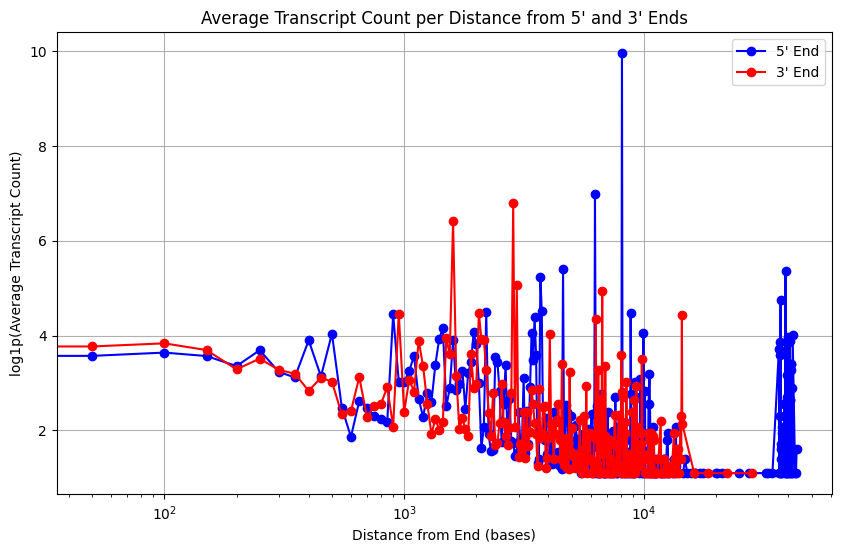

<Figure size 640x480 with 0 Axes>

In [44]:
adata.var['distance_from_5_prime'] = adata.var['start_nucleotide']
adata.var['distance_from_3_prime'] = adata.var['start_nucleotide_reverse']

# Bin the distances
bin_size = 50

# Analyze distance from 5' end
adata.var['distance_5_prime_bin'] = (adata.var['distance_from_5_prime'] // bin_size) * bin_size
bin_summary_5_prime = adata.var.groupby('distance_5_prime_bin')['transcript_count'].mean()

# Analyze distance from 3' end
adata.var['distance_3_prime_bin'] = (adata.var['distance_from_3_prime'] // bin_size) * bin_size
bin_summary_3_prime = adata.var.groupby('distance_3_prime_bin')['transcript_count'].mean()

bin_summary_5_prime = np.log1p(bin_summary_5_prime)
bin_summary_3_prime = np.log1p(bin_summary_3_prime)

# Plot both on the same graph
plt.figure(figsize=(10, 6))
plt.plot(bin_summary_5_prime.index, bin_summary_5_prime.values, marker='o', linestyle='-', color='b', label="5' End")
plt.plot(bin_summary_3_prime.index, bin_summary_3_prime.values, marker='o', linestyle='-', color='r', label="3' End")
plt.xscale('log')
plt.xlabel('Distance from End (bases)')
plt.ylabel('log1p(Average Transcript Count)')
plt.title('Average Transcript Count per Distance from 5\' and 3\' Ends')
plt.legend()
plt.grid(True)
plt.show()

# Save the plot
plt.savefig(f'{output_figure_dir}/average_transcript_count_vs_distance.png', dpi=300)

In [31]:
adata.write_h5ad(f'{output_data_dir}/adata_processed.h5ad')

sorted_genes = adata.var['header'].tolist()
with open(f'{output_data_dir}/sorted_mutations.txt', 'w') as f:
    for item in sorted_genes:
        f.write(f"{item}\n")

with open(f'{output_data_dir}/sorted_mutations_top_100.txt', 'w') as f:
    for item in sorted_genes[:100]:
        f.write(f"{item}\n")